In [1]:
import struct
import socket
import sys
import subprocess
from ast import literal_eval
import time
from datetime import timedelta
from math import sqrt, log
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, make_scorer, accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
####    FEATURE ENGINEERING STAGE: This is where our dataset is concatenated, cleaned and unused columns are dropped

class c:
     OKBLUE = '\033[94m'
     ENDC = '\033[0m'

def tree_important_drop(dataframe, number):
    to_remove = [
        'stopDateTime', 'startDateTime', 'sourceTCPFlagsDescription', 'sourcePort', 
        'destinationTCPFlagsDescription', 'totalSourcePackets', 'destinationPort', 
        'totalSourceBytes', 'source', 'direction', 'totalDestinationBytes', 
        'appName', 'destination', 'totalDestinationPackets', 'protocolName'
    ]
    dataframe = dataframe.drop(labels=to_remove[0:number], axis=1)
    return dataframe

def non_unique_drop(dataframe):
    to_remove = []
    for col in dataframe.columns:
        if len(dataframe[col].unique()) == 1:
            to_remove.append(col)
    dataframe = dataframe.drop(labels=to_remove, axis=1)
    return dataframe

def process_time(time):
    time = time.split(" ")[-1]
    h, m = time.split(":")
    return 3600*int(h)+60*int(m)

csv_files = [
    'data/CSV/TestbedSatJun12Flows.csv',
    'data/CSV/TestbedSunJun13Flows.csv',
    'data/CSV/TestbedMonJun14Flows.csv',
    'data/CSV/TestbedTueJun15Flows.csv',
    'data/CSV/TestbedWedJun16Flows.csv',
    'data/CSV/TestbedThuJun17Flows.csv'
]

attack_dict = {
    'data/CSV/TestbedMonJun14Flows.csv': 'HTTP DOS', 
    'data/CSV/TestbedTueJun15Flows.csv': 'DDOS', 
    'data/CSV/TestbedWedJun16Flows.csv': 'Brute Force',
    'data/CSV/TestbedThuJun17Flows.csv': 'Brute Force SSH', 
    'data/CSV/TestbedSatJun12Flows.csv': 'Brute Force', 
    'data/CSV/TestbedSunJun13Flows.csv': 'Infiltration'
}

dataframe = pd.DataFrame()

for file in csv_files:
    temp_df = pd.read_csv(file)
    temp_df['AttackType'] = attack_dict[file]  # Add the attack type to each dataframe
    dataframe = pd.concat([dataframe, temp_df], ignore_index=True)

# Replace the 'Label' column with the 'AttackType' column
dataframe['Label'] = dataframe['AttackType']
dataframe.drop(columns='AttackType', inplace=True)  # Drop the 'AttackType' column as it's no longer needed

# Keep track of time
totaltime = time.time()

# All columns
col_names = np.array(["generated", "appName", "totalSourceBytes", "totalDestinationBytes", "totalDestinationPackets", "totalSourcePackets", "sourcePayloadAsBase64",
                      "sourcePayloadAsUTF", "destinationPayloadAsBase64", "destinationPayloadAsUTF", "direction", "sourceTCPFlagsDescription", "destinationTCPFlagsDescription",
                      "source", "protocolName", "sourcePort", "destination", "destinationPort", "startDateTime", "stopDateTime", "Label"]
                     )

print(c.OKBLUE + "Reading csv files => Total time elapsed:" + c.ENDC, str(timedelta(seconds=time.time()-totaltime)))

# Drop generated col, because it is uninformative
dataframe.drop(axis=1, columns='generated', inplace=True)
col_names = col_names[1::]
print(c.OKBLUE + "Drop flow-id column => Total time elapsed:" + c.ENDC, str(timedelta(seconds=time.time()-totaltime)))

# Drop payload columns, because I don't know how to make proper features out of them
dataframe.drop(axis=1, columns=["sourcePayloadAsBase64", "sourcePayloadAsUTF",
                                "destinationPayloadAsBase64", "destinationPayloadAsUTF"], inplace=True)
col_names = np.setdiff1d(col_names, np.array(
    ["sourcePayloadAsBase64", "sourcePayloadAsUTF", "destinationPayloadAsBase64", "destinationPayloadAsUTF"]))
print(c.OKBLUE + "Drop payload columns => ", "Total time elapsed" + c.ENDC, str(timedelta(seconds=time.time()-totaltime)))

# Source ip -> numeric
dataframe["source"] = dataframe["source"].apply(
    lambda ip: struct.unpack("!I", socket.inet_aton(ip))[0]
)

# Destination ip -> numeric
dataframe["destination"] = dataframe["destination"].apply(
    lambda ip: struct.unpack("!I", socket.inet_aton(ip))[0]
)
print(c.OKBLUE + "Translate IPs =>  Total time elapsed" +
      c.ENDC, str(timedelta(seconds=time.time()-totaltime)))


dataframe["startDateTime"] = dataframe["startDateTime"].apply(
    lambda time: process_time(time)
)

dataframe["stopDateTime"] = dataframe["stopDateTime"].apply(
    lambda time: process_time(time)
)
print(c.OKBLUE + "Process start / stop datetime =>  Total time elapsed" +
      c.ENDC, str(timedelta(seconds=time.time()-totaltime)))


def flags_transform(flags):
    value = 0
    if type(flags) is str:
        flags = flags.replace(" ", "")
        for c in flags:
            if c != ',':
                value += ord(c)
    return value


dataframe["sourceTCPFlagsDescription"] = dataframe["sourceTCPFlagsDescription"].apply(
    lambda flags: flags_transform(flags)
)

dataframe["destinationTCPFlagsDescription"] = dataframe["destinationTCPFlagsDescription"].apply(
    lambda flags: flags_transform(flags)
)

# Convert categorical
dataframe["protocolName"] = dataframe["protocolName"].astype("category")
dataframe["protocolName"] = dataframe["protocolName"].cat.codes
dataframe["appName"] = dataframe["appName"].astype("category")
dataframe["appName"] = dataframe["appName"].cat.codes
dataframe["direction"] = dataframe["direction"].astype("category")
dataframe["direction"] = dataframe["direction"].cat.codes

# Translate string attack types to numbers
attack_dict = {
    'Normal': 0, 
    'HTTP DOS': 1, 
    'DDOS': 2, 
    'Brute Force': 3,
    'Brute Force SSH': 4, 
    'Infiltration': 5
}

dataframe["Label"] = dataframe["Label"].apply(
    lambda x: attack_dict.get(x, -1)
)
print(c.OKBLUE, "Binarize label => ", "Total time elapsed",
      c.ENDC, str(timedelta(seconds=time.time()-totaltime)))

# Print the distribution of the labels
print(c.OKBLUE, "Label distribution:", c.ENDC)
print(dataframe['Label'].value_counts())

# Fixing the NaN values
dataframe = dataframe.fillna(0)
print(c.OKBLUE, "Fill N/A => ", "Total time elapsed",
      c.ENDC, str(timedelta(seconds=time.time()-totaltime)))

# Drop columns with only 1 unique value
dataframe = non_unique_drop(dataframe)
print(c.OKBLUE, 'Dropped columns with only 1 unique value => ', 'Total time elapsed',
    c.ENDC, str(timedelta(seconds=time.time()-totaltime)))

dataframe = tree_important_drop(dataframe, 0)
print(c.OKBLUE, 'Removed tree features => ', 'Total time elapsed',
    c.ENDC, str(timedelta(seconds=time.time()-totaltime)))

# Neat printing
with pd.option_context('display.max_rows', 1, 'display.max_columns', None):
    print(dataframe)

dataframe.head()

print(dataframe["Label"].value_counts())

dataframe.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/CSV/TestbedSatJun12Flows.csv'

In [ ]:
print(dataframe['Label'].value_counts())
print(dataframe.shape)

Label
3    655456
2    571698
4    397595
5    275528
1    171380
Name: count, dtype: int64
(2071657, 16)


In [ ]:
###    SCALING AND SPLITTING LABELS OFF: We have 3 different scaling methods to choose from

def df_string_impute(dataframe, string, col_names):
    dataframe = dataframe.replace(string, np.nan)
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    dataframe = imp_mean.fit_transform(dataframe.values)
    dataframe = pd.DataFrame(dataframe, columns=col_names)
    return dataframe

def cast_frame(dataframe):
    # Explicitly cast the dataframe, otherwise sklearn's scalers will do that and throw a warning
    dataframe = dataframe.astype(dtype='float64')
    return dataframe

def z_scaler(dataframe, col_names):
    # Scalinfg every feature other than 'Label'
    cols_to_scale = dataframe.columns.difference(['Label'])
    scaler = StandardScaler()
    dataframe[cols_to_scale] = scaler.fit_transform(dataframe[cols_to_scale])
    dataframe = pd.DataFrame(dataframe, columns=col_names)
    return dataframe

def minmax_scaler(dataframe, col_names):
    cols_to_scale = dataframe.columns.difference(['Label'])
    scaler = MinMaxScaler()
    dataframe[cols_to_scale] = scaler.fit_transform(dataframe[cols_to_scale])
    dataframe = pd.DataFrame(dataframe, columns=col_names)
    return dataframe

def split_label_off(dataframe):
    # Look for the label, split the label from the frame
    label_loc = dataframe.columns.get_loc('Label')
    array = dataframe.values
    Y = array[:, label_loc]
    X = np.delete(array, label_loc, 1)
    # Store the data
    data = {'X': X, 'Y': Y}
    print('Label column shape: ', Y.shape, 'Data columns shape: ', X.shape)
    return data

# Dataframe casting
dataframe = cast_frame(dataframe)
print(c.OKBLUE, 'Cast to float64 => ', 'Total time elapsed',
      c.ENDC, str(timedelta(seconds=time.time()-totaltime)))

# Preprocessing -> scaling
print(c.OKBLUE, 'Standardizing scaler', c.ENDC)
dataframe = z_scaler(dataframe, dataframe.columns)
print(c.OKBLUE, 'Z scaling sklearn => ', c.ENDC,
        'Total time elapsed', str(timedelta(seconds=time.time()-totaltime)))

"""
print(c.OKBLUE, 'MinMax scaler', c.ENDC)
dataframe = minmax_scaler(dataframe, dataframe.columns)
print(c.OKBLUE, 'MinMax scaling sklearn => ', c.ENDC,
        'Total time elapsed', str(timedelta(seconds=time.time()-totaltime)))
"""
        
# dataframe = run_pca(dataframe)

data_without_label = split_label_off(dataframe)

data_without_label

# Neat printing
with pd.option_context('display.max_rows', 1, 'display.max_columns', None):
    print(dataframe)

 Cast to float64 =>  Total time elapsed  0:00:51.249301
 Standardizing scaler 
 Z scaling sklearn =>   Total time elapsed 0:00:51.785634
Label column shape:  (2071657,) Data columns shape:  (2071657, 15)
     appName  totalSourceBytes  totalDestinationBytes  \
0  -0.228903         -0.003103              -0.028997   
..       ...               ...                    ...   

    totalDestinationPackets  totalSourcePackets  direction  \
0                 -0.029792           -0.026711   0.331411   
..                      ...                 ...        ...   

    sourceTCPFlagsDescription  destinationTCPFlagsDescription    source  \
0                   -0.621615                       -0.604244  0.082584   
..                        ...                             ...       ...   

    protocolName  sourcePort  destination  destinationPort  startDateTime  \
0      -0.387268    0.412224     1.159882         -0.20898        2.09672   
..           ...         ...          ...              ..

Principal component 1:
[('sourceTCPFlagsDescription', 0.49415328114784174), ('destinationTCPFlagsDescription', 0.4819640004899432), ('direction', 0.1547291747967166), ('totalDestinationPackets', 0.15178137551920237), ('totalSourcePackets', 0.15025541308677995)]
Principal component 2:
[('totalSourcePackets', 0.5487610915462743), ('totalDestinationPackets', 0.5482106989582513), ('totalDestinationBytes', 0.4244852434701299), ('totalSourceBytes', 0.3846193722629913), ('protocolName', 0.11604191936880633)]


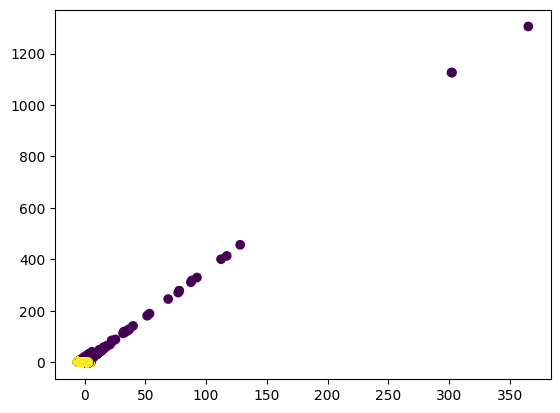

In [ ]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assume X is your dataset
X = dataframe.drop(columns='Label')

# Apply Isolation Forest
clf = IsolationForest(contamination=0.01)
clf.fit(X)
pred = clf.predict(X)

# Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Get the feature names
features = X.columns

# Get the top contributing features for each principal component
for i, component in enumerate(pca.components_):
    feature_contributions = zip(features, component)
    sorted_features = sorted(feature_contributions, key=lambda x: x[1], reverse=True)
    print(f"Principal component {i+1}:")
    print(sorted_features[:5])  # print the top 5 contributing features
    
# Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred)
plt.show()

Before applying machine learning algorithms for anomaly detection on network traffic data, several preprocessing steps are commonly performed:

1. **Feature Selection**: Not all features in the dataset might be useful for detecting anomalies. Features that do not contribute to the model's performance can be dropped. Techniques like mutual information, correlation matrices, or even domain knowledge can be used for feature selection.

2. **Encoding Categorical Variables**: Machine learning algorithms require numerical input. Therefore, categorical variables (like protocol type: TCP, UDP, ICMP, etc.) need to be converted into numerical form. This can be done using techniques like one-hot encoding or label encoding.

3. **Normalization or Standardization**: Features can have different ranges. For example, the number of packets might range from 1 to 1000, while packet lengths might range from 40 to 1500 bytes. These differing ranges can cause issues with some machine learning algorithms. Therefore, it's common to normalize or standardize the data so that all features have a similar range.

4. **Handling Imbalanced Data**: In anomaly detection, the dataset is often highly imbalanced, i.e., there are far fewer anomalous instances than normal instances. This can be handled by techniques like oversampling the minority class, undersampling the majority class, or using a combination of both (SMOTE).

5. **Time-Based Features**: In network traffic data, time can be an important factor. Therefore, creating features that capture the time-based patterns in the data can be useful. This could be features like the count of connections in the last minute/hour/day, time since the last connection, etc.

6. **Aggregation**: Network data is often aggregated into flows, which are sequences of packets traveling in a specific direction between two endpoints. Aggregating the data into flows can help reduce the volume of data and highlight patterns of behavior over time.

7. **Dimensionality Reduction**: If the data has a large number of features, dimensionality reduction techniques like PCA (Principal Component Analysis) or t-SNE can be used to reduce the number of features while retaining the variance in the data.

Remember, the exact preprocessing steps will depend on the specific dataset and the machine learning algorithm being used.

In [ ]:
# SPLITTING TRAINING AND TESTING DATASETS

def train_test_splitter(_input, train_size):
    X_train, X_test, Y_train, Y_test = train_test_split(
        _input['X'], _input['Y'], train_size=train_size, random_state=None, stratify=_input['Y'])
    print("X train samples:", len(X_train))
    print("Y train samples:", len(Y_train),
          np.bincount(Y_train.astype(np.int64)))
    print("X test samples:", len(X_test))
    print("Y test samples:", len(Y_test), np.bincount(Y_test.astype(np.int64)))
    data = {
        'X_train': X_train,
        'Y_train': Y_train,
        'X_test': X_test,
        'Y_test': Y_test
    }
    return data

ratio = 0.8

print(c.OKBLUE, 'Data splitting => ', c.ENDC, 'Total time elapsed',
          str(timedelta(seconds=time.time()-totaltime)))

data_parts_without_label = train_test_splitter(data_without_label, ratio)

data_parts_without_label

 Data splitting =>   Total time elapsed 0:02:26.334567
X train samples: 1657325
Y train samples: 1657325 [     0 137104 457358 524365 318076 220422]
X test samples: 414332
Y test samples: 414332 [     0  34276 114340 131091  79519  55106]


{'X_train': array([[ 2.60608432e+00, -1.95263337e-03, -2.83075900e-02, ...,
         -1.66884424e-01,  1.08501002e+00,  1.09197738e+00],
        [-2.77781712e-01, -2.77867478e-03, -2.81854514e-02, ...,
         -2.08979788e-01, -3.02059397e-01, -3.03959214e-01],
        [-2.77781712e-01, -2.39558311e-03, -2.71190557e-02, ...,
         -2.08979788e-01,  1.07621254e+00,  1.08024682e+00],
        ...,
        [-2.28902627e-01, -2.75739191e-03, -2.88879586e-02, ...,
         -2.08979788e-01,  4.33996467e-01,  4.32133404e-01],
        [-2.77781712e-01, -7.12906163e-04,  3.10946937e-02, ...,
         -2.08979788e-01,  1.15538986e+00,  1.15356282e+00],
        [-2.77781712e-01, -2.77335406e-03, -2.85367050e-02, ...,
         -2.08979788e-01, -2.34612047e-01, -2.36508496e-01]]),
 'Y_train': array([2., 5., 2., ..., 4., 3., 3.]),
 'X_test': array([[-7.66572564e-01, -3.12984214e-03, -2.88517382e-02, ...,
         -2.12110848e-01, -1.59528902e+00, -1.59725341e+00],
        [-2.77781712e-01, -2.781

In [ ]:
# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(data_parts_without_label["X_train"], data_parts_without_label["Y_train"])

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

In [ ]:
# Create a DecisionTreeClassifier with the best parameters
dtree_best = DecisionTreeClassifier(criterion='entropy', max_depth=None, 
                                    min_samples_leaf=1, min_samples_split=2, 
                                    random_state=42)

# Fit the model to the training data
dtree_best.fit(data_parts_without_label["X_train"], data_parts_without_label["Y_train"])

# Predict the labels for the test set
predictions = dtree_best.predict(data_parts_without_label["X_test"])

# Print the classification report
print(classification_report(data_parts_without_label["Y_test"], predictions))

              precision    recall  f1-score   support

         1.0       0.78      0.78      0.78     34276
         2.0       0.90      0.89      0.90    114340
         3.0       0.88      0.87      0.87    131091
         4.0       0.87      0.86      0.87     79519
         5.0       0.89      0.94      0.91     55106

    accuracy                           0.88    414332
   macro avg       0.86      0.87      0.87    414332
weighted avg       0.88      0.88      0.88    414332



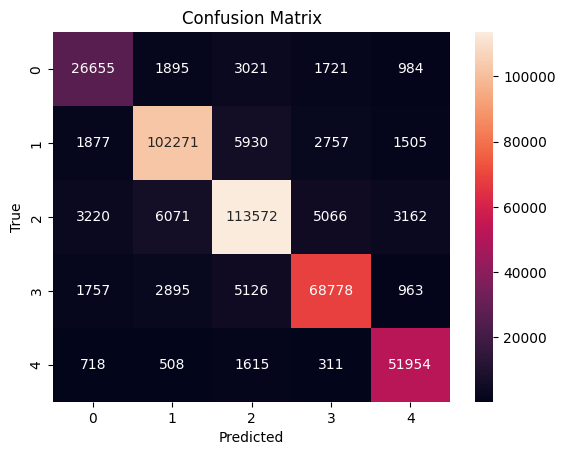

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix
cm = confusion_matrix(data_parts_without_label["Y_test"], predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()